In [1]:
import os
import torch
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from hvs_hsi_pytorch.hs_image import HSImage
from hvs_hsi_pytorch.hsicamera_simulator import HSICameraSimulator
from hvs_hsi_pytorch.utils import utils
from hvs_hsi_pytorch.definitions import DIR_DATA

### Load Monte Carlo Data

In [2]:
mc_path = os.path.join(DIR_DATA, "monte_carlo/dkfz/colon_train.csv")

mc_reflectance = pd.read_csv(mc_path, skiprows=[0], usecols=list(range(26, 171)))
wavelengths_mc = np.arange(430, 720, 2)
mc_reflectance.columns = wavelengths_mc

mc_sto2 = pd.read_csv(mc_path, skiprows=[0], usecols=[2])
mc_sto2.columns = ['StO2']

In [ ]:
mc_reflectance

In [4]:
mc_sto2.head()

,StO2
0,0.223244
1,0.319150
2,0.042802
3,0.282085
4,0.731168


### Prepare Monte Carlo HSImage

In [5]:
monte_carlo_data = torch.from_numpy(np.array(mc_reflectance).T[..., np.newaxis])
monte_carlo_wavelengths = torch.from_numpy(wavelengths_mc)

It is important here to specify `camera = None`.

In [6]:
monte_carlo_hsimage = HSImage(array=monte_carlo_data, wavelengths=monte_carlo_wavelengths, camera=None)

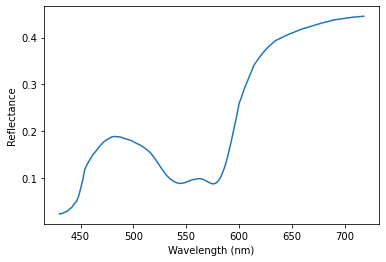

In [7]:
plt.plot(monte_carlo_hsimage.wavelengths, torch.mean(torch.squeeze(monte_carlo_hsimage.array), dim=1))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance');

### Simulate imec Camera

To convert Monte Carlo data into equivalent imec data, it is important to use the method shown below.

In [8]:
imec_camera = HSICameraSimulator(camera="imec 4x4-VIS-15.7.15.4")
monte_carlo_imec = imec_camera(monte_carlo_hsimage)

On line 42 of `camera_simulate_pipeline.py` you used `image_spectrum = HSImage(image_spectrum, wavelengths=spectrum, camera="imec 4x4-VIS-15.7.15.4")` which does not do the simulation correctly.

Text(0, 0.5, 'Reflectance')

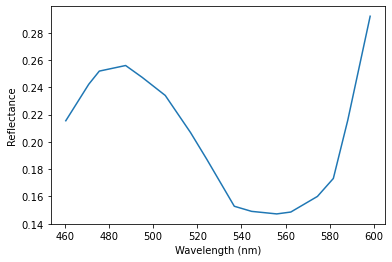

In [9]:
plt.plot(monte_carlo_imec.wavelengths, torch.mean(torch.squeeze(monte_carlo_imec.array), dim=1))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')

### Compare Original and Simulated Monte Carlo Data

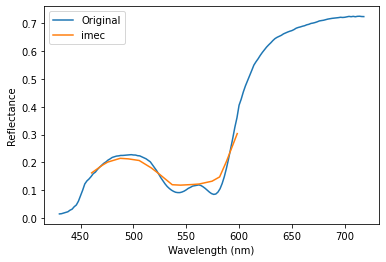

In [10]:
idx = 716

plt.plot(monte_carlo_hsimage.wavelengths, monte_carlo_hsimage.array[:, idx, :], label='Original')
plt.plot(monte_carlo_imec.wavelengths, monte_carlo_imec.array[:, idx, :], label='imec')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()

### L1 Normalise imec Monte Carlo Data

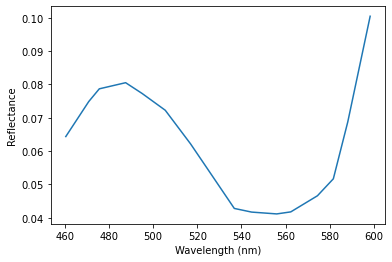

In [11]:
monte_carlo_imec_L1_norm = deepcopy(monte_carlo_imec)
monte_carlo_imec_L1_norm.array = utils.normalise_L1(monte_carlo_imec_L1_norm.array)
plt.plot(monte_carlo_imec_L1_norm.wavelengths, torch.mean(torch.squeeze(monte_carlo_imec_L1_norm.array), dim=1))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance');

### Compare Data to 'colon_train_reformatted'

In [12]:
path = "./data/colon_train_reformatted.csv"
SC_reflectance = pd.read_csv(path, usecols=list(range(24, 169)))
wavelengths_SC = np.arange(430, 720, 2)
SC_reflectance.columns = wavelengths_SC
SC_reflectance.head()

,430,432,434,436,438,440,442,444,446,448,...,700,702,704,706,708,710,712,714,716,718
0,0.053353,0.051692,0.052761,0.053731,0.058697,0.071239,0.080473,0.100438,0.115432,0.145919,...,0.476016,0.476873,0.477694,0.477000,0.478240,0.477896,0.478369,0.478943,0.479408,0.479868
1,0.031095,0.030573,0.031819,0.032633,0.035943,0.044081,0.050094,0.063781,0.074343,0.095704,...,0.485749,0.486539,0.487691,0.488371,0.490212,0.489625,0.491092,0.492806,0.492699,0.493697
2,0.027259,0.025814,0.025787,0.026048,0.028457,0.035058,0.040103,0.051835,0.061142,0.080692,...,0.485355,0.486292,0.488280,0.488636,0.490821,0.491549,0.492510,0.493993,0.495434,0.496265
3,0.016509,0.016049,0.016623,0.017191,0.018765,0.023674,0.027603,0.036346,0.043405,0.059543,...,0.507781,0.508263,0.509845,0.511099,0.513043,0.513738,0.514716,0.516082,0.515919,0.517048
4,0.001712,0.001848,0.002048,0.002308,0.002589,0.003144,0.003570,0.004540,0.005383,0.007681,...,0.454460,0.454370,0.454225,0.454747,0.454153,0.454136,0.454053,0.454209,0.453968,0.454216


In [13]:
monte_carlo_data_SC = torch.from_numpy(np.array(SC_reflectance).T[..., np.newaxis])
monte_carlo_wavelengths_SC = torch.from_numpy(wavelengths_SC)
monte_carlo_hsimage_SC = HSImage(array=monte_carlo_data_SC, wavelengths=monte_carlo_wavelengths_SC, camera=None)

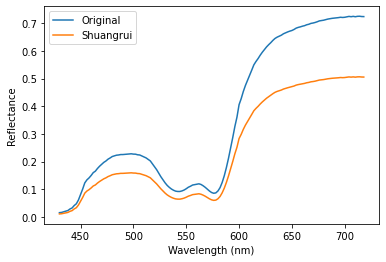

In [14]:
idx = 716

plt.plot(monte_carlo_hsimage.wavelengths, monte_carlo_hsimage.array[:, idx, :], label='Original')
plt.plot(monte_carlo_hsimage_SC.wavelengths, monte_carlo_hsimage_SC.array[:, idx, :], label='Shuangrui')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend();

### Reuben Simulator Pipeline

In [15]:
import src.utils as srcutils

from hvs_hsi_pytorch.imec_sensor import ImecSensor
from hvs_hsi_pytorch.imec_operators import SpectralCorrectionImecOperator

#### Asahi Light Source

In [16]:
CAMERAS = [
    '15.7.10.12',
    '15.7.14.2',
    '15.7.15.4',
    '15.7.16.7'
]

LIGHTS = [
    'asahi',
    'd_light_c',
    'power_led_300',
    'sunoptic_x450',
    'torch',
    'xenon_nova_300'
]

i_camera = 3
i_light = 0

In [17]:
columns = mc_reflectance.columns.to_list()
# Load data
reflectances = monte_carlo_imec.array
wavelengths = monte_carlo_imec.wavelengths

sensor_name = 'imec 4x4-VIS-' + CAMERAS[i_camera]
sensor = ImecSensor(sensor_name)

# Load the light spectrum info
light = srcutils.load_spectrum(
    path_spectrum=os.path.join('./data/spectrometer', LIGHTS[i_light] + '.txt'),
    light=LIGHTS[i_light], wavelengths_ref=wavelengths)

# Light spectrum * Image reflectance
reflectance_under_light_array = torch.einsum('ijk,i->ijk', reflectances, light)
reflectance_under_light = HSImage(
    array=reflectance_under_light_array,
    wavelengths=wavelengths,
    precision=torch.float16
)

# Unormalized spectral response
spectrum_response_img, _ = srcutils.get_camera_response(reflectance_under_light, sensor_name, precision=torch.float32)

# Compute normalisation factor
light_modified_array = light[:, None, None]
light_modified = HSImage(
    array=light_modified_array,
    wavelengths=wavelengths
)
spectrum_response_light, _ = srcutils.get_camera_response(light_modified, sensor_name, precision=torch.float32)
normalisation_factor = spectrum_response_light.mean()

# Apply normalisation
spectrum_response_img /= normalisation_factor

# Save data frame
spectrum_response_img, out_wavelengths = SpectralCorrectionImecOperator(sensor_id=sensor_name, precision=torch.float32)(
    spectrum_response_img)
# spectrum_response_img = torch.squeeze(torch.swapaxes(spectrum_response_img, 0, 2))
# target_param = torch.tensor(mc_sto2.to_numpy())
# reformatted_data = torch.cat((target_param, spectrum_response_img), dim=1).numpy()
# columns += list(map(str, out_wavelengths.numpy()))
# output = pd.DataFrame(reformatted_data, columns=columns)

In [18]:
monte_carlo_imec.wavelengths, out_wavelengths

(tensor([460.4685, 470.8591, 475.6402, 487.5597, 495.0627, 505.4955, 516.9379,
         524.2993, 536.7569, 544.5972, 555.9696, 562.3306, 574.3978, 581.5989,
         588.1238, 598.2659]),
 tensor([460.2114, 466.3534, 476.2722, 483.0096, 494.6562, 506.2266, 512.9200,
         525.0596, 534.4048, 545.0434, 551.9792, 564.0675, 570.4451, 581.9135,
         588.8975, 596.3077]))

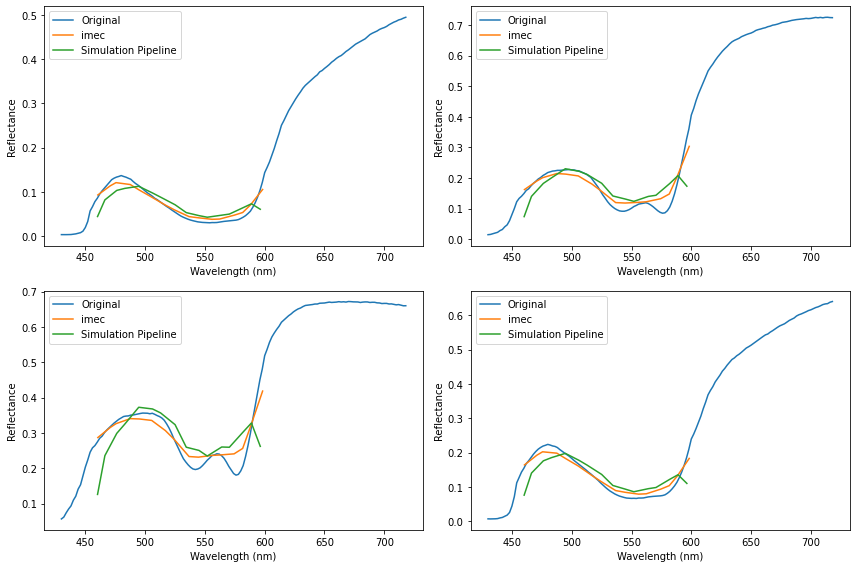

In [19]:
idxs = [25, 716, 1042, 1389]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flatten()):
    ax.plot(monte_carlo_hsimage.wavelengths, monte_carlo_hsimage.array[:, idxs[i], :], label='Original')
    ax.plot(monte_carlo_imec.wavelengths, monte_carlo_imec.array[:, idxs[i], :], label='imec')
    ax.plot(out_wavelengths, spectrum_response_img[:, idxs[i], :], label='Simulation Pipeline')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Reflectance')
    ax.legend()

plt.tight_layout()

#### Sunoptic x450 Light Source

In [20]:
i_camera = 3
i_light = 3

In [21]:
columns = mc_reflectance.columns.to_list()
# Load data
reflectances = monte_carlo_imec.array
wavelengths = monte_carlo_imec.wavelengths

sensor_name = 'imec 4x4-VIS-' + CAMERAS[i_camera]
sensor = ImecSensor(sensor_name)

# Load the light spectrum info
light = srcutils.load_spectrum(
    path_spectrum=os.path.join('./data/spectrometer', LIGHTS[i_light] + '.txt'),
    light=LIGHTS[i_light], wavelengths_ref=wavelengths)

# Light spectrum * Image reflectance
reflectance_under_light_array = torch.einsum('ijk,i->ijk', reflectances, light)
reflectance_under_light = HSImage(
    array=reflectance_under_light_array,
    wavelengths=wavelengths,
    precision=torch.float16
)

# Unormalized spectral response
spectrum_response_img, _ = srcutils.get_camera_response(reflectance_under_light, sensor_name, precision=torch.float32)

# Compute normalisation factor
light_modified_array = light[:, None, None]
light_modified = HSImage(
    array=light_modified_array,
    wavelengths=wavelengths
)
spectrum_response_light, _ = srcutils.get_camera_response(light_modified, sensor_name, precision=torch.float32)
normalisation_factor = spectrum_response_light.mean()

# Apply normalisation
spectrum_response_img /= normalisation_factor
# spectrum_response_img = normalise_L1(spectrum_response_img)

# spec_response_light /= normalisation_factor

# Save data frame
spectrum_response_img, out_wavelengths = SpectralCorrectionImecOperator(sensor_id=sensor_name, precision=torch.float32)(
    spectrum_response_img)
# spectrum_response_img = torch.squeeze(torch.swapaxes(spectrum_response_img, 0, 2))
# target_param = torch.tensor(mc_sto2.to_numpy())
# reformatted_data = torch.cat((target_param, spectrum_response_img), dim=1).numpy()
# columns += list(map(str, out_wavelengths.numpy()))
# output = pd.DataFrame(reformatted_data, columns=columns)

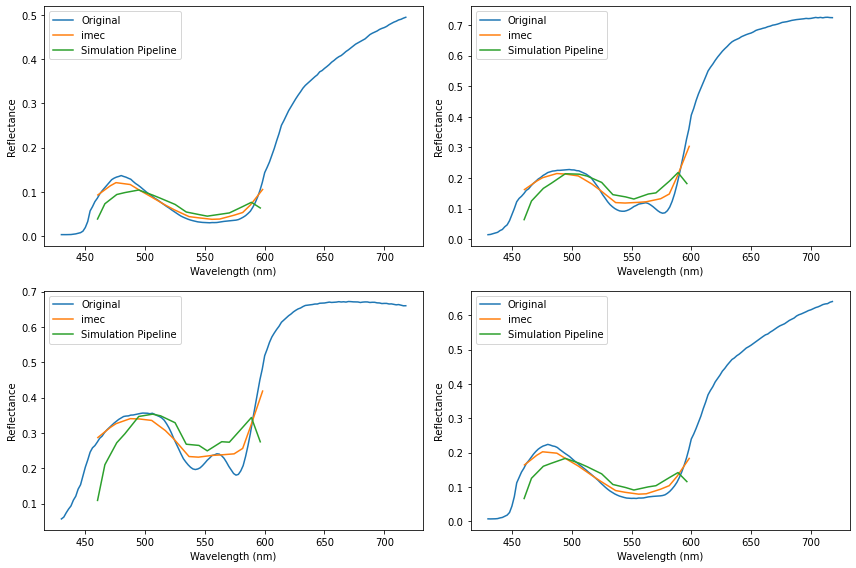

In [22]:
idxs = [25, 716, 1042, 1389]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flatten()):
    ax.plot(monte_carlo_hsimage.wavelengths, monte_carlo_hsimage.array[:, idxs[i], :], label='Original')
    ax.plot(monte_carlo_imec.wavelengths, monte_carlo_imec.array[:, idxs[i], :], label='imec')
    ax.plot(out_wavelengths, spectrum_response_img[:, idxs[i], :], label='Simulation Pipeline')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Reflectance')
    ax.legend()

plt.tight_layout()